# Brain Age (Big) Explore

FS6.0-data from ADNI, AIBL, IXI, SLIM, SALD and CalgaryCampinas

2020-01-22 A.L.

In [1]:
# Import all libraries needed for the exploration

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd #this is how we usually import pandas
import numpy as np #this is how we usually import numpy
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
#import tables # pytables is needed to read and write hdf5 files
#import openpyxl # is used to read and write MS Excel files
import scipy.stats as stats

#import xgboost
import math
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import tree, linear_model
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

# Enable inline plotting
%matplotlib inline

In [2]:
# Supress some warnings:
import warnings
warnings.filterwarnings('ignore')

In [3]:
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)
print('Matplotlib version ' + matplotlib.__version__)
print('Seaborn version ' + sns.__version__)

Python version 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
Pandas version 0.25.3
Numpy version 1.17.5
Matplotlib version 2.2.4
Seaborn version 0.9.0


# Big data

## Read training data

In [4]:
ADNI = pd.read_csv('../data/mri/ADNI_info.csv')
train = ADNI.copy()

## Read NIFTI image (using fsleyes)

https://users.fmrib.ox.ac.uk/~paulmc/fsleyes/userdoc/latest/fsleyes_notebook.html

### Starting FSLeyes from IPython/Jupyter


https://users.fmrib.ox.ac.uk/~paulmc/fsleyes/apidoc/latest/fsleyes.html

To start FSLeyes from a running IPython/Jupyter Notebook session, you first need to enable GUI integration:

In [5]:
%gui wx

Then you can call the fsleyes.main.embed() function to start FSLeyes:

In [6]:
import fsleyes.main as main
overlayList, displayCtx, frame = main.embed()
frame.Show()

True

You now have references to an OverlayList, the master DisplayContext, and the FSLeyesFrame, and can use their programming interfaces to interact with FSLeyes. For example, to open an ortho view, and add an image:

In [7]:
import os.path as op
from fsleyes.views.orthopanel import OrthoPanel
from fsl.data.image import Image

ortho = frame.addViewPanel(OrthoPanel)
#overlayList.append(Image(op.expandvars('$FSLDIR/data/standard/MNI152_T1_2mm')))
overlayList.append(Image(op.expandvars('../data/mri/t1_mprage_sag_p2_iso.nii.gz')))

### FSL tools

https://users.fmrib.ox.ac.uk/~paulmc/fsleyes/fslpy/latest/

`conda install -c conda-forge fslpy`

In [8]:
from fsl.data.image import Image
struc = Image('../data/mri/t1_mprage_sag_p2_iso.nii.gz')

`help(bet)`

In [9]:
from fsl.wrappers.bet import bet
bet(struc, '../data/mri/t1_mprage_betted.nii.gz', 'robust')

{}

In [10]:
#overlayList.append(Image(op.expandvars('../data/mri/t1_mprage_betted.nii.gz')))

## Explore training data

In [11]:
# Check the number of data points in the training set
print('No observations:', len(train))
# Check the number of features in the training set
print('No variables:', len(train.columns))
# Check the data types
print(train.dtypes.unique())

No observations: 7294
No variables: 241
[dtype('int64') dtype('O') dtype('float64')]


In [12]:
train.shape

(7294, 241)

In [13]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative

['RID',
 'SITE',
 'AGE',
 'PTEDUCAT',
 'APOE4',
 'FDG',
 'PIB',
 'AV45',
 'CDRSB',
 'ADAS11',
 'ADAS13',
 'ADASQ4',
 'MMSE',
 'RAVLT_immediate',
 'RAVLT_learning',
 'RAVLT_forgetting',
 'RAVLT_perc_forgetting',
 'LDELTOTAL',
 'DIGITSCOR',
 'TRABSCOR',
 'FAQ',
 'MOCA',
 'EcogPtMem',
 'EcogPtLang',
 'EcogPtVisspat',
 'EcogPtPlan',
 'EcogPtOrgan',
 'EcogPtDivatt',
 'EcogPtTotal',
 'EcogSPMem',
 'EcogSPLang',
 'EcogSPVisspat',
 'EcogSPPlan',
 'EcogSPOrgan',
 'EcogSPDivatt',
 'EcogSPTotal',
 'FLDSTRENG',
 'IMAGEUID',
 'mPACCdigit',
 'mPACCtrailsB',
 'CDRSB_bl',
 'ADAS11_bl',
 'ADAS13_bl',
 'ADASQ4_bl',
 'MMSE_bl',
 'RAVLT_immediate_bl',
 'RAVLT_learning_bl',
 'RAVLT_forgetting_bl',
 'RAVLT_perc_forgetting_bl',
 'LDELTOTAL_BL',
 'DIGITSCOR_bl',
 'TRABSCOR_bl',
 'FAQ_bl',
 'mPACCdigit_bl',
 'mPACCtrailsB_bl',
 'FLDSTRENG_bl',
 'MOCA_bl',
 'EcogPtMem_bl',
 'EcogPtLang_bl',
 'EcogPtVisspat_bl',
 'EcogPtPlan_bl',
 'EcogPtOrgan_bl',
 'EcogPtDivatt_bl',
 'EcogPtTotal_bl',
 'EcogSPMem_bl',
 'EcogSP

In [14]:
not_allowed_quant = ['RID',
 'SITE',
 'PTEDUCAT',
 'APOE4',
 'FDG',
 'PIB',
 'AV45',
 'CDRSB',
 'ADAS11',
 'ADAS13',
 'ADASQ4',
 'MMSE',
 'RAVLT_immediate',
 'RAVLT_learning',
 'RAVLT_forgetting',
 'RAVLT_perc_forgetting',
 'LDELTOTAL',
 'DIGITSCOR',
 'TRABSCOR',
 'FAQ',
 'MOCA',
 'EcogPtMem',
 'EcogPtLang',
 'EcogPtVisspat',
 'EcogPtPlan',
 'EcogPtOrgan',
 'EcogPtDivatt',
 'EcogPtTotal',
 'EcogSPMem',
 'EcogSPLang',
 'EcogSPVisspat',
 'EcogSPPlan',
 'EcogSPOrgan',
 'EcogSPDivatt',
 'EcogSPTotal',
 'FLDSTRENG',
 'IMAGEUID',
 'mPACCdigit',
 'mPACCtrailsB',
 'CDRSB_bl',
 'ADAS11_bl',
 'ADAS13_bl',
 'ADASQ4_bl',
 'MMSE_bl',
 'RAVLT_immediate_bl',
 'RAVLT_learning_bl',
 'RAVLT_forgetting_bl',
 'RAVLT_perc_forgetting_bl',
 'LDELTOTAL_BL',
 'DIGITSCOR_bl',
 'TRABSCOR_bl',
 'FAQ_bl',
 'mPACCdigit_bl',
 'mPACCtrailsB_bl',
 'FLDSTRENG_bl',
 'MOCA_bl',
 'EcogPtMem_bl',
 'EcogPtLang_bl',
 'EcogPtVisspat_bl',
 'EcogPtPlan_bl',
 'EcogPtOrgan_bl',
 'EcogPtDivatt_bl',
 'EcogPtTotal_bl',
 'EcogSPMem_bl',
 'EcogSPLang_bl',
 'EcogSPVisspat_bl',
 'EcogSPPlan_bl',
 'EcogSPOrgan_bl',
 'EcogSPDivatt_bl',
 'EcogSPTotal_bl',
 'FDG_bl',
 'PIB_bl',
 'AV45_bl',
 'Years_bl',
 'Month_bl',
 'Month',
 'M']

In [15]:
train_quant = [var for var in quantitative if var not in not_allowed_quant]

In [16]:
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']
qualitative

['PTID',
 'VISCODE',
 'COLPROT',
 'ORIGPROT',
 'EXAMDATE',
 'DX_bl',
 'PTGENDER',
 'PTETHCAT',
 'PTRACCAT',
 'PTMARRY',
 'ABETA',
 'TAU',
 'PTAU',
 'DX',
 'EXAMDATE_bl',
 'ABETA_bl',
 'TAU_bl',
 'PTAU_bl',
 'update_stamp',
 'ID',
 'lh.aparc.thickness',
 'rh.aparc.thickness']

In [17]:
not_allowed_qual = ['PTID',
 'VISCODE',
 'COLPROT',
 'ORIGPROT',
 'EXAMDATE',
 'DX_bl',
 'PTETHCAT',
 'PTRACCAT',
 'PTMARRY',
 'ABETA',
 'TAU',
 'PTAU',
 'DX',
 'EXAMDATE_bl',
 'ABETA_bl',
 'TAU_bl',
 'PTAU_bl',
 'update_stamp',
 'ID',
 'lh.aparc.thickness',
 'rh.aparc.thickness']

In [18]:
train_qual = [var for var in qualitative if var not in not_allowed_qual]

# missing 78


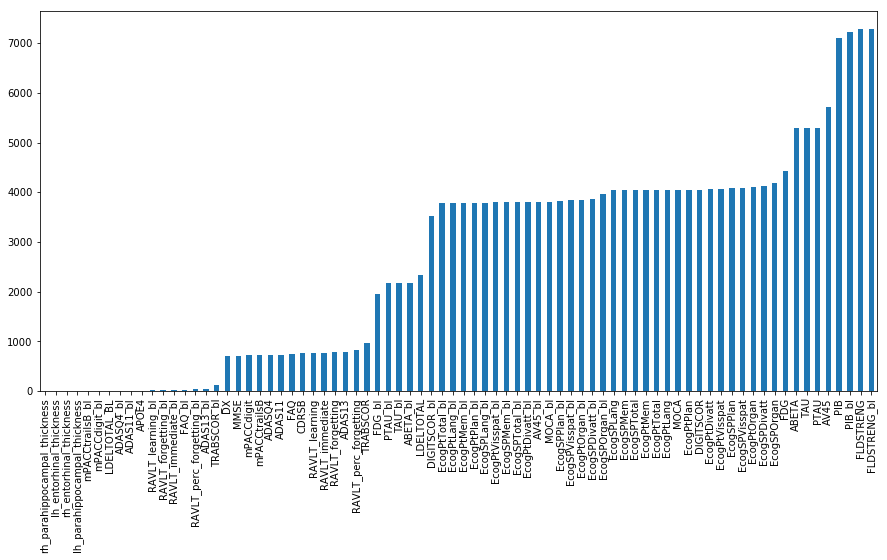

In [19]:
plt.figure(figsize=(15,7))
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
print('# missing',len(missing))
missing.plot.bar()
plt.show()

x attributes have missing values, 4 over 50% of all data. Most of times NA means lack of subject described by attribute.

### Fit different probability ditributions to the Age distribution

See also https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/

https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html#sphx-glr-auto-examples-neighbors-plot-kde-1d-py

In [20]:
np.min(train['AGE']), np.max(train['AGE'])

(54.4, 90.9)

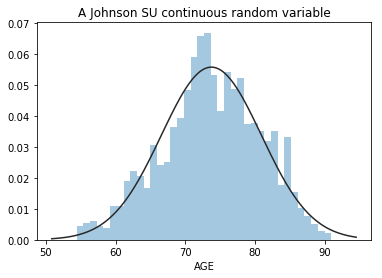

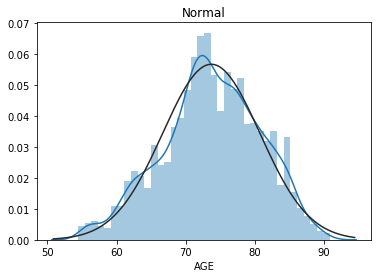

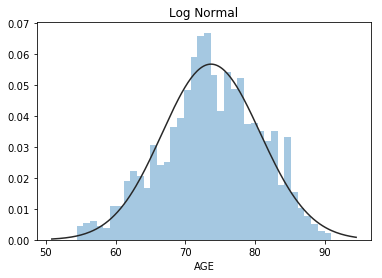

In [21]:
import scipy.stats as st
y = train['AGE']
plt.figure(1); plt.title('A Johnson SU continuous random variable')
sns.distplot(y, kde=False, fit=st.johnsonsu)  # st.johnsonsu??
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=True, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)
plt.show()

i.e. it is apparent that Age is close to a normal distribution, so before performing regression it doeas not have to be transformed.

### Side-note on KDE distributions

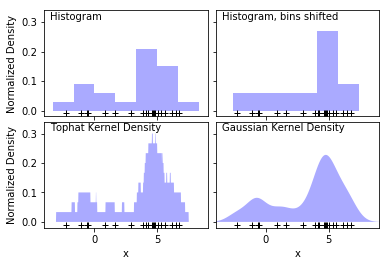

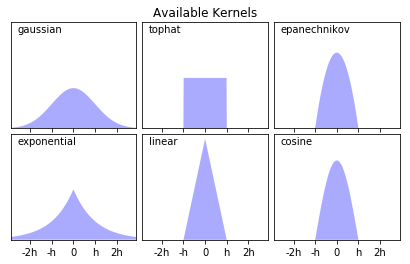

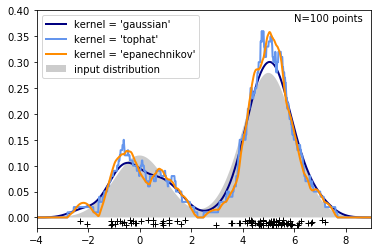

In [22]:
# Author: Jake Vanderplas <jakevdp@cs.washington.edu>
#
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

# `normed` is being deprecated in favor of `density` in histograms
if LooseVersion(matplotlib.__version__) >= '2.1':
    density_param = {'density': True}
else:
    density_param = {'normed': True}

# ----------------------------------------------------------------------
# Plot the progression of histograms to kernels
np.random.seed(1)
N = 20
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# histogram 1
ax[0, 0].hist(X[:, 0], bins=bins, fc='#AAAAFF', **density_param)
ax[0, 0].text(-3.5, 0.31, "Histogram")

# histogram 2
ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc='#AAAAFF', **density_param)
ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), '+k')
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel('Normalized Density')

for axi in ax[1, :]:
    axi.set_xlabel('x')

# ----------------------------------------------------------------------
# Plot all available kernels
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)


def format_func(x, loc):
    if x == 0:
        return '0'
    elif x == 1:
        return 'h'
    elif x == -1:
        return '-h'
    else:
        return '%ih' % x

for i, kernel in enumerate(['gaussian', 'tophat', 'epanechnikov',
                            'exponential', 'linear', 'cosine']):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), '-k', fc='#AAAAFF')
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title('Available Kernels')

# ----------------------------------------------------------------------
# Plot a 1D density example
N = 100
np.random.seed(1)
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0])
             + 0.7 * norm(5, 1).pdf(X_plot[:, 0]))

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
        label='input distribution')
colors = ['navy', 'cornflowerblue', 'darkorange']
kernels = ['gaussian', 'tophat', 'epanechnikov']
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), color=color, lw=lw,
            linestyle='-', label="kernel = '{0}'".format(kernel))

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc='upper left')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

In [23]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


i.e. Also none of quantitative variables has normal distribution so these should be transformed as well.

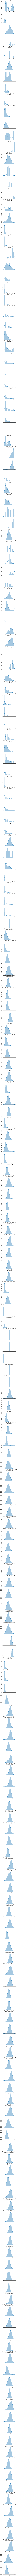

In [29]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=1, sharex=False, sharey=False, height=4, aspect=1.5)
g = g.map(sns.distplot, "value")
plt.show()

TO BE CONTINUED (cf. https://www.kaggle.com/dgawlik/house-prices-eda#Categorical-data)

In [ ]:
train.columns

List features (column names)in training data

In [ ]:
for i, col in enumerate(data.columns, start=0):
    print(i, col)

In [ ]:
# We may have some categorical features, let's check them
data.select_dtypes(include=['O']).columns.tolist()

In [ ]:
# Check any number of columns with NaN
print(data.isnull().any().sum(), ' / ', len(data.columns))
# Check number of data points with any NaN
print(data.isnull().any(axis=1).sum(), ' / ', len(data))

## Select complete list of features and the target

In [ ]:
features = data.iloc[:,9:-1].columns.tolist()
target = data.iloc[:,-1].name

# Feature engineering

In [ ]:
CortexVol = data.lhCortexVol+data.rhCortexVol

In [ ]:
LateralVentricleVol = data['Left-Lateral-Ventricle']+data['Right-Lateral-Ventricle']

In [ ]:
HippocampusVol = data['Left-Hippocampus']+data['Right-Hippocampus']

In [ ]:
df = pd.DataFrame({'CortexVol': CortexVol,
                   'LateralVentricleVol': LateralVentricleVol,
                   'HippocampusVol': HippocampusVol})

In [ ]:
df.plot('CortexVol', 'LateralVentricleVol', kind='scatter')
plt.show()

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title='Pandas Profiling Report')

In [ ]:
profile

# Make X and y

In [ ]:
X = df.as_matrix()

In [ ]:
X.shape

# Extra

In [ ]:
all_lh_features = [
 'CSF', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior', 'CC_Anterior', 'EstimatedTotalIntraCranialVol',
 'Left-Lateral-Ventricle',
 'Left-Inf-Lat-Vent',
 'Left-Cerebellum-White-Matter',
 'Left-Cerebellum-Cortex',
 'Left-Thalamus-Proper',
 'Left-Caudate',
 'Left-Putamen',
 'Left-Pallidum',
 'Left-Hippocampus',
 'Left-Amygdala',
 'Left-Accumbens-area',
 'Left-VentralDC',
 'Left-vessel',
 'Left-choroid-plexus',
 'Left-WM-hypointensities',
 'Left-non-WM-hypointensities',
 'lhCortexVol',
 'lhCerebralWhiteMatterVol',            
 'lhSurfaceHoles',  
 'lh_bankssts_thickness',
 'lh_caudalanteriorcingulate_thickness',
 'lh_caudalmiddlefrontal_thickness',
 'lh_cuneus_thickness',
 'lh_entorhinal_thickness',
 'lh_fusiform_thickness',
 'lh_inferiorparietal_thickness',
 'lh_inferiortemporal_thickness',
 'lh_isthmuscingulate_thickness',
 'lh_lateraloccipital_thickness',
 'lh_lateralorbitofrontal_thickness',
 'lh_lingual_thickness',
 'lh_medialorbitofrontal_thickness',
 'lh_middletemporal_thickness',
 'lh_parahippocampal_thickness',
 'lh_paracentral_thickness',
 'lh_parsopercularis_thickness',
 'lh_parsorbitalis_thickness',
 'lh_parstriangularis_thickness',
 'lh_pericalcarine_thickness',
 'lh_postcentral_thickness',
 'lh_posteriorcingulate_thickness',
 'lh_precentral_thickness',
 'lh_precuneus_thickness',
 'lh_rostralanteriorcingulate_thickness',
 'lh_rostralmiddlefrontal_thickness',
 'lh_superiorfrontal_thickness',
 'lh_superiorparietal_thickness',
 'lh_superiortemporal_thickness',
 'lh_supramarginal_thickness',
 'lh_frontalpole_thickness',
 'lh_temporalpole_thickness',
 'lh_transversetemporal_thickness',
 'lh_insula_thickness',
 'lh_MeanThickness_thickness'
 ]

In [ ]:
# Make rh_ and Right- names (base on LHs)

# List comprehensions
rh_names = [w.replace('lh_', 'rh_') for w in all_lh_features]
Right_names = [w.replace('Left-', 'Right-') for w in rh_names]
most_rh_names = [w.replace('lhC', 'rhC') for w in Right_names]
all_rh_names = [w.replace('lhS', 'rhS') for w in most_rh_names]
all_rh_features = [w.replace('lh.', 'rh.') for w in all_rh_names]
all_rh_features

In [ ]:
data_lh = data[all_lh_features]
pd.DataFrame(data_lh.count())

In [ ]:
data_lh.describe().T

In [ ]:
dropcolumns = [
    'EstimatedTotalIntraCranialVol',
    'CSF', 
    'CC_Posterior', 
    'CC_Mid_Posterior', 
    'CC_Central', 
    'CC_Mid_Anterior', 
    'CC_Anterior'   
]

df_lh = data_lh.drop(dropcolumns, axis=1)
df_lh

In [ ]:
target

### Discretization of Age variable
Quantile-based discretization function. Discretize variable into equal-sized buckets based on rank or based on sample quantiles. For example 1000 values for 10 quantiles would produce a Categorical object indicating quantile membership for each data point.

In [ ]:
pd.qcut(data['Age'], 17).head(1)

#### Columns with missing values

In [ ]:
def missing(dff):
    print (round((dff.isnull().sum() * 100/ len(dff)),4).sort_values(ascending=False))

In [ ]:
missing(df_lh)

#### How to remove columns with too many missing values in Python
https://stackoverflow.com/questions/45515031/how-to-remove-columns-with-too-many-missing-values-in-python

In [ ]:
def rmissingvaluecol(dff,threshold):
    l = []
    l = list(dff.drop(dff.loc[:,list((100*(dff.isnull().sum()/len(dff.index))>=threshold))].columns, 1).columns.values)
    print("# Columns having more than %s percent missing values:"%threshold,(dff.shape[1] - len(l)))
    print("Columns:\n",list(set(list((dff.columns.values))) - set(l)))
    return l

In [ ]:
#Here threshold is 10% which means we are going to drop columns having more than 10% of missing values
rmissingvaluecol(data,10)

In [ ]:
# Now create new dataframe excluding these columns
l = rmissingvaluecol(data,10)
data1 = data[l]

In [ ]:
# missing(data[features])

#### Correlations between features and target

In [ ]:
correlations = {}
for f in features:
    data_temp = data1[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [ ]:
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

#### We can see that the top 5 features are the most correlated features with the target "Age"

In [ ]:
y = data.loc[:,['lh_insula_thickness','rh_insula_thickness',target]].sort_values(target, ascending=True).values
x = np.arange(y.shape[0])

In [ ]:
%matplotlib inline
plt.subplot(3,1,1)
plt.plot(x,y[:,0])
plt.title('lh_insula_thickness and rh_insula_thickness vs Age')
plt.ylabel('lh_insula_thickness')

plt.subplot(3,1,2)
plt.plot(x,y[:,1])
plt.ylabel('rh_insula_thickness')

plt.subplot(3,1,3)
plt.plot(x,y[:,2],'r')
plt.ylabel("Age")

plt.show()

### Predicting Age

In [ ]:
# Train a simple linear regression model
regr = linear_model.LinearRegression()
new_data = data[features]

In [ ]:
X = new_data.values
y = data.Age.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)

In [ ]:
regr.fit(X_train, y_train)
print(regr.predict(X_test))

In [ ]:
regr.score(X_test,y_test)

In [ ]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))

In [ ]:
# Let's try XGboost algorithm to see if we can get better results
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [ ]:
traindf, testdf = train_test_split(X_train, test_size = 0.3)
xgb.fit(X_train,y_train)

In [ ]:
predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

### This is worse than a simple regression model

We can use `.describe()` to calculate simple **descriptive statistics** for the dataset (rounding to 3 decimals):

In [ ]:
new_data.describe().round(3).T

Computing the **pairwise correlation of columns** (features). Method could be ‘pearson’ (default), ‘kendall’, or ‘spearman’. 

In [ ]:
new_data.corr().round(2)

In [ ]:
new_data.describe()

Splitting the object (iris DataFrame) **into groups** (species)

In [ ]:
grouped = data.groupby('Sex')

In [ ]:
grouped.groups

Describe the group-wise `PetalLength` summary statistics

In [ ]:
print('Age:')
grouped['Age'].describe()

Iterating through the grouped data is very natural

In [ ]:
for name, group in grouped:
    print(name,':')
    print(group.describe().round(2).head(3))

**Group-wise feature correlations**

In [ ]:
data.groupby('Age').corr().round(3)

DataFrame has an `assign()` method that allows you to easily create new columns that are potentially derived from existing columns.

In [ ]:
iris.assign(sepal_ratio = iris['SepalWidth'] / iris['SepalLength']).head().round(3)

In the example above, we inserted a precomputed value. <br>
We can also pass in a function of one argument to be evaluated on the DataFrame being assigned to.

In [ ]:
iris.assign(sepal_ratio = lambda x: (x['SepalWidth'] /
                                     x['SepalLength'])).head().round(3)

`assign` always returns a copy of the data, leaving the original DataFrame untouched, e.g.

In [ ]:
iris.head(2)

Passing a callable, as opposed to an actual value to be inserted, is useful when you don’t have a reference to the DataFrame at hand. This is common when using assign``  in a chain of operations. For example, we can limit the DataFrame to just those observations with a Sepal Length greater than 5, calculate the ratio, and plot:

In [ ]:
(iris.query('SepalLength > 5')
 .assign(SepalRatio = lambda x: x.SepalWidth / x.SepalLength,
         PetalRatio = lambda x: x.PetalWidth / x.PetalLength)
 .plot(kind='scatter', x='SepalRatio', y='PetalRatio'))

### Classification

*Organizing data as X and y before classification*

In [ ]:
from sklearn.preprocessing import LabelEncoder

# dfX5Y = pd.read_csv('../results/02_X5Y.csv', sep=',')
# print(dfX5Y.info())
# print(dfX5Y.describe())
# dfX5Y

# Featuer importance XGBoost:
# X = df.loc[:, ['CC_Mid_Anterior_w3', 'BrainSegVol-to-eTIV_w3', 'CSF_w2']] # Top three important features
# Featuer importance RF (Strrop_3):
X = df.loc[:, ['BrainSegVol-to-eTIV_w3', 'CC_Mid_Anterior_w3', 'ic04-ic02']] # Top three important features
# Featuer importance RF predicrting Stroop_1_R_3:
# X = df.loc[:, ['ic09-ic06', 'ic10-ic01', 'ic05-ic03']] # Top three important features
# Featuer importance RF predicrting Stroop_2_R_3:
# X = df.loc[:, ['WM-hypointensities_w3', 'ic17-ic04', 'Left-vessel_w3']] # Top three important features
# X = df.loc[:, ['BrainSegVol-to-eTIV_w3', 'ic04-ic02']] # Two important features
# X = df.loc[:, ['BrainSegVol-to-eTIV_w3', 'CC_Mid_Anterior_w3']] # Top two important features
Y = df.loc[:, ['Stroop_3_cat']]
y = Y.as_matrix().ravel()
np.unique(y)
X.columns

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing

# X = dfX5Y.loc[:, dfX5Y.columns != 'grp']      # Top five important connections
# X = dfX5Y.loc[:, ['ic09-ic02', 'ic04-ic01']]   # Top two important connections
# X = df.loc[:, ['LatVent_w2', 'LatVent_w3', 'ic09-ic02', 'ic04-ic01']]
# X = df.loc[:, ['LatVent_w3', 'ic09-ic02']]
# X = df.loc[:, ['LatVent_w2', 'LatVent_w3']]
# Y = df.loc[:, ['Stroop_3_cat']]

# X = df.loc[:, ['BrainSegVol-to-eTIV_w3', 'CC_Mid_Anterior_w3', 'ic04-ic02']]
# Y = df.loc[:, ['Stroop_3_cat']]
# y = Y.as_matrix().ravel()

rs = 42 # random_state (42)
hls = 3 # MLP hidden layer size (3 or 4)
# https://stackoverflow.com/questions/37659970/how-does-sklearn-compute-the-precision-score-metric
myaverage = 'weighted' # For multilabel classification  'micro', 'macro', 'samples', 'weighted'
# see: https://stackoverflow.com/questions/37659970/how-does-sklearn-compute-the-precision-score-metric

# http://scikit-learn.org/stable/modules/neural_networks_supervised.html
# Class MLPClassifier implements a multi-layer perceptron (MLP) algorithm that 
# trains using Backpropagation.

# So what about size of the hidden layer(s)--how many neurons? 
# There are some empirically-derived rules-of-thumb, of these, the most 
# commonly relied on is 'the optimal size of the hidden layer is usually 
# between the size of the input and size of the output layers'. 
# Jeff Heaton, author of Introduction to Neural Networks in Java offers a few more.
#
# In sum, for most problems, one could probably get decent performance (even without 
# a second optimization step) by setting the hidden layer configuration using j
# ust two rules: 
#  (i) number of hidden layers equals one; and 
# (ii) the number of neurons in that layer is the mean of the neurons in the 
#      input and output layers.
# Compute the precision
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and 
# fp the number of false positives. The precision is intuitively the ability of the 
# classifier not to label as positive a sample that is negative.

# Compute the recall
# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and 
# fn the number of false negatives. The recall is intuitively the ability of the 
# classifier to find all the positive samples.

# Compute the F1 score, also known as balanced F-score or F-measure
# The F1 score can be interpreted as a weighted average of the precision and recall, 
# where an F1 score reaches its best value at 1 and worst score at 0. 
# The relative contribution of precision and recall to the F1 score are equal. 
# The formula for the F1 score is:
#    F1 = 2 * (precision * recall) / (precision + recall)
# In the multi-class and multi-label case, this is the weighted average of the F1 score of each class.

pipe_clf1 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf1', LogisticRegression(C=1., solver='saga', n_jobs=1, 
                                multi_class='multinomial', random_state=rs))])

pipe_clf2 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf2', MLPClassifier(hidden_layer_sizes=(hls, ),   # =(100, )  ; =(4, )
                          activation='relu', solver='adam',
                          alpha=0.0001, batch_size='auto', learning_rate='constant',
                          learning_rate_init=0.001, power_t=0.5, max_iter=5000,
                          shuffle=True, random_state=rs, tol=0.0001, verbose=False,
                          warm_start=False, momentum=0.9, nesterovs_momentum=True,
                          early_stopping=False, validation_fraction=0.1,
                          beta_1=0.9, beta_2=0.999, epsilon=1e-08))])

# pipe_clf3 = Pipeline([
#     ('scl', StandardScaler()),
#     #('pca', PCA(n_components=2)),
#     ('clf3', RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None,
#                                   min_samples_split=2, min_samples_leaf=1,
#                                   min_weight_fraction_leaf=0.0, max_features='auto',
#                                   max_leaf_nodes=None,     #  min_impurity_split=1e-07,
#                                   bootstrap=True, oob_score=False, n_jobs=1,
#                                   random_state=rs, verbose=0, warm_start=False,
#                                   class_weight=None))])
# pipe_clf3 = Pipeline([
#     ('scl', StandardScaler()),
#     #('pca', PCA(n_components=2)),
#     ('clf3', GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
#                                         max_depth=None, max_features=None, max_leaf_nodes=None,
#                                         min_samples_leaf=1, min_samples_split=2,
#                                         min_weight_fraction_leaf=0.0, n_estimators=100,
#                                         presort='auto', random_state=rs, subsample=1.0, verbose=0,
#                                         warm_start=False)

pipe_clf3 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf3', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
                           gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
                           min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
                           objective='multi:softprob', reg_alpha=0, reg_lambda=1,
                           scale_pos_weight=1, seed=rs, silent=True, subsample=1))])
     
pipe_clf4 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf4', SVC(C=1.0, probability=True, random_state=rs))])
#    ('clf4', SVC(C=1.0, random_state=rs))])
    
pipe_clf5 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf5', KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree', 
                           leaf_size=30, p=2, metric='minkowski', 
                           metric_params=None, n_jobs=1))])

pipe_clf_vote =  Pipeline([
#    ('scl', StandardScaler()),
    ('clf_vote', VotingClassifier(
        estimators=[('lr', pipe_clf1), 
                 ('mlp', pipe_clf2),
                 ('rf', pipe_clf3),
                 ('svc', pipe_clf4),
                 ('knn', pipe_clf5)],
     voting = 'soft'))])
#     voting = 'hard'))])

scores1_acc, scores2_acc, scores3_acc, scores4_acc, scores5_acc, scores_vote_acc = [], [], [], [], [], []
scores1_pre, scores2_pre, scores3_pre, scores4_pre, scores5_pre, scores_vote_pre = [], [], [], [], [], []
scores1_rec, scores2_rec, scores3_rec, scores4_rec, scores5_rec, scores_vote_rec = [], [], [], [], [], []
scores1_f1, scores2_f1, scores3_f1, scores4_f1, scores5_f1, scores_vote_f1 = [], [], [], [], [], []

n_splits = 10  # k=10
# n_splits = X.shape[0]   # i.e.  Leave One Out strategy
# for train_index, test_index in LeaveOneOut.split(X):

k=1
for train_index, test_index in \
StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rs).split(X,y):
    print("Fold number:", k)
    #print("\nTRUE class:\n", list(y[test_index]))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    
    #clf1 = LogisticRegression
    print(" - LogisticRegression")
    pipe_clf1.fit(X_train, y_train)
    scores1_acc.append(accuracy_score(y_test, pipe_clf1.predict(X_test)))
    scores1_pre.append(precision_score(y_test, pipe_clf1.predict(X_test), average=myaverage))
    scores1_rec.append(recall_score(y_test, pipe_clf1.predict(X_test), average=myaverage))
    scores1_f1.append(f1_score(y_test, pipe_clf1.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf1.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf1.predict(X_test), average=myaverage)))
    #print("LR predicted:\n", list(pipe_clf1.predict(X_test)))
    
    #clf2 = MLPClassifier
    print(" - MLPClassifier")
    pipe_clf2.fit(X_train, y_train)
    scores2_acc.append(accuracy_score(y_test, pipe_clf2.predict(X_test)))
    scores2_pre.append(precision_score(y_test, pipe_clf2.predict(X_test), average=myaverage))
    scores2_rec.append(recall_score(y_test, pipe_clf2.predict(X_test), average=myaverage))
    scores2_f1.append(f1_score(y_test, pipe_clf2.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf2.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf2.predict(X_test), average=myaverage)))
    #print("MLP predicted:\n", list(pipe_clf2.predict(X_test)))
    
    #clf3 = RandomForestClassifier
    #print(" - RandomForestClassifier")
    #clf3 = XGBoost
    print(" - XGBoost")
    pipe_clf3.fit(X_train, y_train)
    scores3_acc.append(accuracy_score(y_test, pipe_clf3.predict(X_test)))
    scores3_pre.append(precision_score(y_test, pipe_clf3.predict(X_test), average=myaverage))
    scores3_rec.append(recall_score(y_test, pipe_clf3.predict(X_test), average=myaverage))
    scores3_f1.append(f1_score(y_test, pipe_clf3.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf3.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf3.predict(X_test), average=myaverage)))
    #print("RF predicted:\n", list(pipe_clf3.predict(X_test)))
    #print("XGB predicted:\n", list(pipe_clf3.predict(X_test)))
    
    #clf4 = svm.SVC()
    print(" - svm/SVC")
    pipe_clf4.fit(X_train, y_train)
    scores4_acc.append(accuracy_score(y_test, pipe_clf4.predict(X_test)))
    scores4_pre.append(precision_score(y_test, pipe_clf4.predict(X_test), average=myaverage))
    scores4_rec.append(recall_score(y_test, pipe_clf4.predict(X_test), average=myaverage))
    scores4_f1.append(f1_score(y_test, pipe_clf4.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf4.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf4.predict(X_test), average=myaverage)))
    #print("SVM predicted:\n", list(pipe_clf4.predict(X_test)))
    
        #clf5 = KNeighborsClassifier
    print(" - KNN")
    pipe_clf5.fit(X_train, y_train)
    scores5_acc.append(accuracy_score(y_test, pipe_clf5.predict(X_test)))
    scores5_pre.append(precision_score(y_test, pipe_clf5.predict(X_test), average=myaverage))
    scores5_rec.append(recall_score(y_test, pipe_clf5.predict(X_test), average=myaverage))
    scores5_f1.append(f1_score(y_test, pipe_clf5.predict(X_test), average=myaverage))
    #print("KNN predicted:\n", list(pipe_clf5.predict(X_test)))
    
    #clf_vote = VotingClassifier
    print(" - VotingClassifier")
    pipe_clf_vote.fit(X_train, y_train)
    scores_vote_acc.append(accuracy_score(y_test, pipe_clf_vote.predict(X_test)))
    scores_vote_pre.append(precision_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage))
    scores_vote_rec.append(recall_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage))
    scores_vote_f1.append(f1_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage)))
    k=k+1
    
print('\nPredictors:')
print('X.columns = %s' % list(X.columns))

print('\nOutcome:')
print(pd.qcut(df['Stroop_3_R_3'], 3).head(0))
print(np.unique(y))

print('\nSome hyperparameters:')
print("MLP hidden_layer_size = %d" % (hls))
print("random_state = %d" % (rs))
print("score average = '%s'" % (myaverage))

print("\nLR : CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores1_acc), np.std(scores1_acc), n_splits))
print("MLP: CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores2_acc), np.std(scores2_acc), n_splits))
# print("RF : CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores3_acc), np.std(scores3_acc), n_splits))
print("XGB : CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores3_acc), np.std(scores3_acc), n_splits))
print("SVM: CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores4_acc), np.std(scores4_acc), n_splits))
print("KNN: CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores5_acc), np.std(scores5_acc), n_splits))
print("Voting: CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores_vote_acc), np.std(scores_vote_acc), n_splits))

print("\nLR : CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores1_pre), np.std(scores1_pre), n_splits))
print("MLP: CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores2_pre), np.std(scores2_pre), n_splits))
print("XGB : CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores3_pre), np.std(scores3_pre), n_splits))
print("SVM: CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores4_pre), np.std(scores4_pre), n_splits))
print("KNN: CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores5_pre), np.std(scores5_pre), n_splits))
print("Voting: CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores_vote_pre), np.std(scores_vote_pre), n_splits))

print("\nLR : CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores1_rec), np.std(scores1_rec), n_splits))
print("MLP: CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores2_rec), np.std(scores2_rec), n_splits))
print("XGB : CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores3_rec), np.std(scores3_rec), n_splits))
print("SVM: CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores4_rec), np.std(scores4_rec), n_splits))
print("KNN: CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores5_rec), np.std(scores5_rec), n_splits))
print("Voting: CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores_vote_rec), np.std(scores_vote_rec), n_splits))

print("\nLR : CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores1_f1), np.std(scores1_f1), n_splits))
print("MLP: CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores2_f1), np.std(scores2_f1), n_splits))
print("XGB : CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores3_f1), np.std(scores3_f1), n_splits))
print("SVM: CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores4_f1), np.std(scores4_f1), n_splits))
print("KNN: CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores5_f1), np.std(scores5_f1), n_splits))
print("Voting: CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores_vote_f1), np.std(scores_vote_f1), n_splits))